# Brunel 10K Neuron Network Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numba import jit
from scipy.stats import ks_2samp, pearsonr


%matplotlib inline

In [2]:
plt.style.use('seaborn-paper')
SMALL_SIZE = 35
MEDIUM_SIZE = 45
BIGGER_SIZE = 45

plt.rc('font', size=SMALL_SIZE, family="Arial")          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', color="black")          # controls default text sizes

plt.rcParams['axes.linewidth'] = 5.0
plt.rcParams['figure.figsize'] = (20.0, 10.0)


%matplotlib inline

#### Loading auryn weights

In [3]:
from scipy.io import mmread
aurynweightmatrix = mmread('../auryn/network.0.0.wmat')

#### Loading NEST weights

In [4]:
# Loading nest weights
nestweights = np.loadtxt("../pyNest/PlasticSynapseWeights.txt")

#### Loading ANNarchy weights

In [5]:
# Loading nest weights
annarchyweights = np.loadtxt("../ANNarchy/plasticweights.txt")

#### Loading Brian2 weights

In [6]:
# Loading nest weights
brian2weights = np.loadtxt("../brian2/plasticweights.txt")

#### Loading Spike weights

In [7]:
prefile = "../Spike/Build/BRUNELPLASTIC_PresynapticIDs.bin"
postfile = "../Spike/Build/BRUNELPLASTIC_PostsynapticIDs.bin"
weightfile = "../Spike/Build/BRUNELPLASTIC_SynapticWeights.bin"


spike_network_df = pd.DataFrame(data = {"pre": np.fromfile(prefile, dtype=np.int32), "post": np.fromfile(postfile, dtype=np.int32), "weight": np.fromfile(weightfile, dtype=np.float32)})

In [8]:
spikeweights = spike_network_df["weight"]

### Loading GeNN weights

In [9]:
weightfile = "../genn/Weights.bin"
gennweights = np.fromfile(weightfile, dtype=np.float32)

### Plotting Weight Histograms after 20s of Simulation

In [10]:
data = [
    nestweights,
    spikeweights.values*1000,
    aurynweightmatrix.data*1000,
    annarchyweights.flatten(),
    brian2weights,
    gennweights
]

labels = [
    "NEST",
    "Spike",
    "Auryn",
    "ANNarchy",
    "Brian2",
    "GeNN"
]

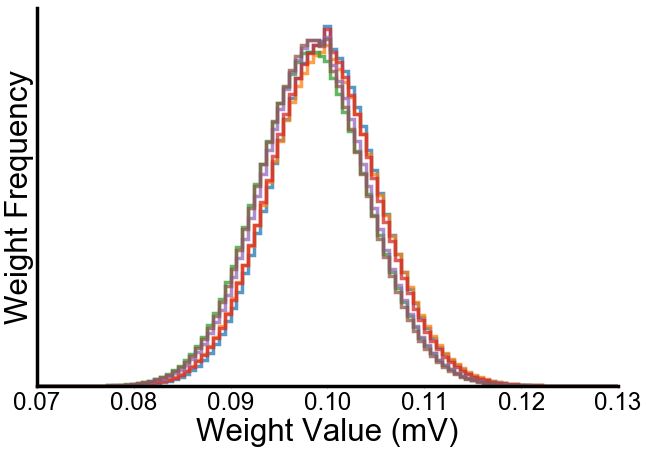

In [11]:
colours = plt.rcParams['axes.prop_cycle'].by_key()['color'] #['red', 'green', 'blue', 'orange', 'magenta', 'black']

# mylinestyles = ['-' , '--' , '-.' , ':' , '-', '--']

fig = plt.figure(figsize=(15,10), dpi=50)
ax = plt.subplot(1, 1, 1)
binvals = np.linspace(0.07,0.13,100)

for sim in range(len(data)):
    _ = ax.hist(data[sim], bins=binvals, color=colours[sim], label=labels[sim], histtype='step', alpha=0.75, linewidth=5)

# plt.legend()
plt.xlabel("Weight Value (mV)")
plt.ylabel("Weight Frequency")
# ax.xaxis.set_tick_params(labelsize=11)
plt.xlim([0.07, 0.13])
_ = plt.yticks([])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.savefig('weightRange_comparison.png', dpi=300)


### Kolmogorov-Smirnov 2 Sample Testing to Compare Distributions

In [12]:
# Sample some random % of weights 10 times and use these to do some statistical analysis
numberofsamples = 10
samplesize=1000.0
sampleindices = []

np.random.seed(42)
for t in range(numberofsamples):
    sampleindices.append(np.random.randint(0,high=len(nestweights), size=int(samplesize)))

In [13]:
weight_ks = np.zeros((len(data), len(data), numberofsamples, numberofsamples))

for d1 in range(len(data)):
    for d2 in range(len(data)):
        for s1 in range(numberofsamples):
            for s2 in range(numberofsamples):
                weight_ks[d1,d2,s1,s2] = ks_2samp(data[d1][sampleindices[s1]], data[d2][sampleindices[s2]])[1]

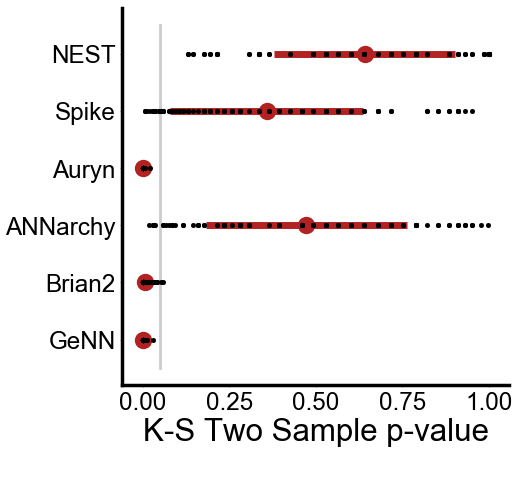

In [14]:
# %%capture
plt.figure(figsize=(10,10), dpi=50)

tickvalues = []
count = 0
d1 = 0 # Comparing against samples from NEST

for d2 in range(len(data)):
    plt.errorbar(np.mean(weight_ks[d1,d2]), [-1*count], fmt=".", ms=50, lw=10, color='firebrick', xerr=np.std(weight_ks[d1,d2].flatten()), zorder=-1)
    plt.scatter(weight_ks[d1,d2].flatten(), -1*count*np.ones(weight_ks[d1,d2].flatten().shape), s=50, color='k')
    tickvalues.append(labels[d2])
    count += 1
        
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot([0.05, 0.05], [0.5,-5.5], lw=4, zorder=-5, color='k', alpha=0.2)


plt.xlabel("K-S Two Sample p-value\n")
_ = plt.yticks(-1*np.arange(count), tickvalues, rotation='horizontal')

Comparing Simulators to Auryn to Check for 2 Distributions

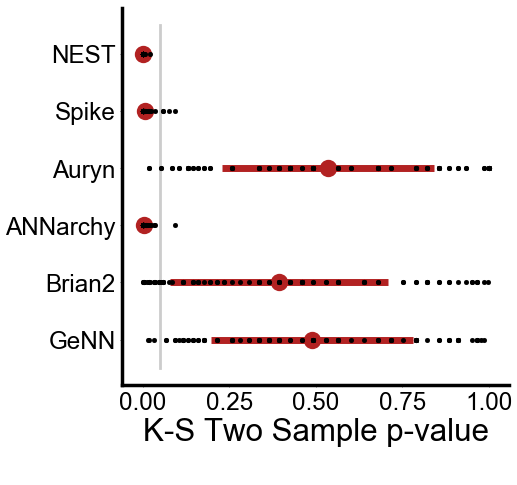

In [15]:
# %%capture
plt.figure(figsize=(10,10), dpi=50)

tickvalues = []
count = 0
d1 = 2 # Comparing against Auryn

for d2 in range(len(data)):
    plt.errorbar(np.mean(weight_ks[d1,d2]), [-1*count], fmt=".", ms=50, lw=10, color='firebrick', xerr=np.std(weight_ks[d1,d2].flatten()), zorder=-1)
    plt.scatter(weight_ks[d1,d2].flatten(), -1*count*np.ones(weight_ks[d1,d2].flatten().shape), s=50, color='k')
    tickvalues.append(labels[d2])
    count += 1
        
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot([0.05, 0.05], [0.5,-5.5], lw=4, zorder=-5, color='k', alpha=0.2)


plt.xlabel("K-S Two Sample p-value\n")
_ = plt.yticks(-1*np.arange(count), tickvalues, rotation='horizontal')